# Control co-design and sensitivity analysis of the LUPA’s PTO using WecOptTool

Carlos A. **Michelén~Ströfer**, Michael **Devin**, Ryan G. **Coe**, Courtney **Beringer**, Bret **Bosma**, Daniel **Gaebele**, Giorgio **Bacelli**, and Bryson **Robertson**


In [1]:
import gmsh, pygmsh
import capytaine as cpy
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
import xarray as xr
from scipy.optimize import brute

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

#### Float

In [2]:
# mass properties
float_mass_properties = {
    'mass': 248.721,
    'CG': [0.01, 0, 0.06],
    'MOI': [66.1686, 65.3344, 17.16],
}

# mesh
mesh_size_factor = 0.3
r1 = 1.0/2  # top radius
r2 = 0.4/2  # bottom radius
h1 = 0.5  
h2 = 0.21
freeboard = 0.3
r3 = 0.10/2 + 0.05  # hole radius

with pygmsh.occ.Geometry() as geom:
    gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
    cyl = geom.add_cylinder([0, 0, 0], [0, 0, -h1], r1)
    cone = geom.add_cone([0, 0, -h1], [0, 0, -h2], r1, r2)
    geom.translate(cyl, [0, 0, freeboard])
    geom.translate(cone, [0, 0, freeboard])
    hole = False
    if hole:
        tmp = geom.boolean_union([cyl, cone])
        bar = geom.add_cylinder([0, 0, 10], [0,0,-20], r3)
        geom.boolean_difference(tmp, bar)
    else:
        geom.boolean_union([cyl, cone])
    mesh_float = geom.generate_mesh()

# floating body
float_fb = cpy.FloatingBody.from_meshio(mesh_float, name='float')
float_fb.add_translation_dof(name='Heave')

#### Spar

In [3]:
# mass properties
spar_mass_properties = {
    'mass': 175.536,
    'CG': [0, 0, -1.3],
    'MOI': [253.6344, 250.4558, 12.746],
}

# mesh
mesh_size_factor = 0.1
r1 = 0.45/2  # body
r2 = 0.45  # plate
r3 = 0.10/2  # bar
h1 = 1.20  
h2 = 0.01
h3a = 3.684 - 2.05
submergence = 2.05 - h1 - h2

with pygmsh.occ.Geometry() as geom:
    gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
    body = geom.add_cylinder([0, 0, 0], [0, 0, -h1], r1)
    geom.translate(body, [0, 0, -submergence])
    plate = geom.add_cylinder([0, 0, 0], [0, 0, -h2], r2)
    geom.translate(plate, [0, 0, -(submergence+h1)])
    bar = geom.add_cylinder([0, 0, h3a], [0, 0, -(h3a+submergence)], r3)
    geom.boolean_union([bar, body, plate])
    mesh_spar = geom.generate_mesh()

# floating body
spar_fb = cpy.FloatingBody.from_meshio(mesh_spar, name='spar')
spar_fb.add_translation_dof(name='Heave')

#### Combined

In [4]:
# density of fresh water
rho = 1000

# floating body
lupa_fb = float_fb + spar_fb
lupa_fb.name = 'LUPA'

# mass properties float
mass_float = float_mass_properties['mass'] 
cm_float = np.array(float_mass_properties['CG'])
pitch_inertia_float = float_mass_properties['MOI'][1] 

# mass properties spar
mass_spar = spar_mass_properties['mass']  
cm_spar = np.array(spar_mass_properties['CG'])
pitch_inertia_spar = spar_mass_properties['MOI'][1] 

 # mass properties LUPA
lupa_fb.center_of_mass = ((mass_float*cm_float + mass_spar*cm_spar)
                        / (mass_float + mass_spar))
lupa_fb.rotation_center = lupa_fb.center_of_mass

# pitch moment of inertia of LUPA using the parallel axis theorem 
d_float = cm_float[2] - lupa_fb.center_of_mass[2]
d_spar = cm_spar[2] - lupa_fb.center_of_mass[2]
pitch_inertia = (
    pitch_inertia_float + mass_float*d_float**2 + 
    pitch_inertia_spar + mass_spar*d_spar**2
)
inertia = np.diag([mass_float, mass_spar, lupa_fb.disp_mass(), pitch_inertia])

# additional DOFs
lupa_fb.add_translation_dof(name='Surge')
lupa_fb.add_rotation_dof(name='Pitch')

### BEM

In [6]:
# compute hydrodynamic coefficients
f1 = 0.02
nfreq = 50
freq = wot.frequency(f1, nfreq, False)

# read BEM data file if it exists
filename = './data/bem.nc'
try:
    bem_data = wot.read_netcdf(filename)
except:
    bem_data = wot.run_bem(lupa_fb, freq)
    wot.write_netcdf(filename, bem_data)

# hydrostatics
_ = lupa_fb.compute_hydrostatics(rho=rho)
hydrostatic_stiffness = lupa_fb.hydrostatic_stiffness

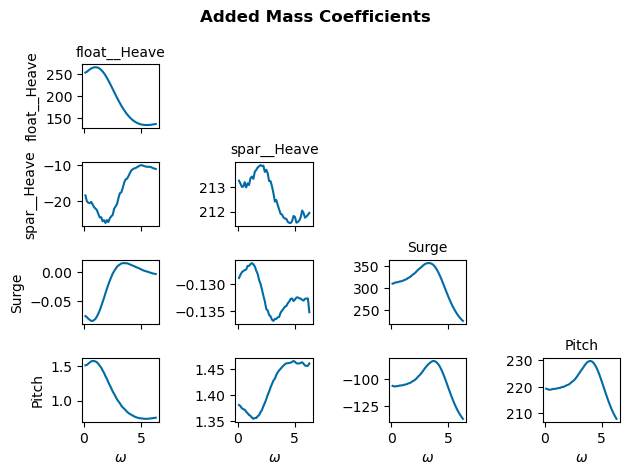

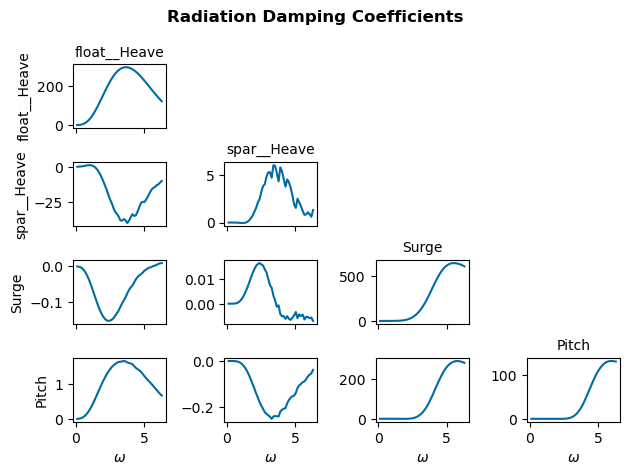

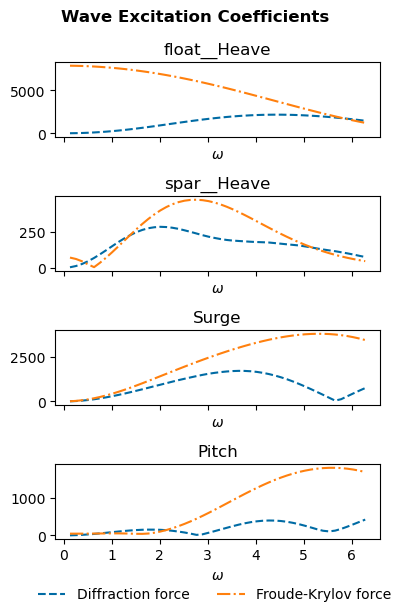

In [7]:
# plot coefficients
radiating_dofs = bem_data.radiating_dof.values
influenced_dofs = bem_data.influenced_dof.values

# plots
fig_am, ax_am = plt.subplots(len(radiating_dofs), len(influenced_dofs),
                             tight_layout=True, sharex=True)
fig_rd, ax_rd = plt.subplots(len(radiating_dofs), len(influenced_dofs),
                             tight_layout=True, sharex=True)
fig_ex, ax_ex = plt.subplots(len(influenced_dofs), 1,
                             tight_layout=True, sharex=True, figsize=(4, 6))

# plot titles
fig_am.suptitle('Added Mass Coefficients', fontweight='bold')
fig_rd.suptitle('Radiation Damping Coefficients', fontweight='bold')
fig_ex.suptitle('Wave Excitation Coefficients', fontweight='bold')

# subplotting across 4DOF
sp_idx = 0
for i, rdof in enumerate(radiating_dofs):
    for j, idof in enumerate(influenced_dofs):
        sp_idx += 1
        if i == 0:
            np.abs(bem_data.diffraction_force.sel(influenced_dof=idof)).plot(
                ax=ax_ex[j], linestyle='dashed', label='Diffraction force')
            np.abs(bem_data.Froude_Krylov_force.sel(influenced_dof=idof)).plot(
                ax=ax_ex[j], linestyle='dashdot', label='Froude-Krylov force')
            ex_handles, ex_labels = ax_ex[j].get_legend_handles_labels()
            ax_ex[j].set_title(f'{idof}')
            ax_ex[j].set_xlabel('')
            ax_ex[j].set_ylabel('')
        if j <= i:
            bem_data.added_mass.sel(
                radiating_dof=rdof, influenced_dof=idof).plot(ax=ax_am[i, j])
            bem_data.radiation_damping.sel(
                radiating_dof=rdof, influenced_dof=idof).plot(ax=ax_rd[i, j])
            if i == len(radiating_dofs)-1:
                ax_am[i, j].set_xlabel(f'$\omega$', fontsize=10)
                ax_rd[i, j].set_xlabel(f'$\omega$', fontsize=10)
                ax_ex[j].set_xlabel(f'$\omega$', fontsize=10)
            else:
                ax_am[i, j].set_xlabel('')
                ax_rd[i, j].set_xlabel('')
            if j == 0:
                ax_am[i, j].set_ylabel(f'{rdof}', fontsize=10)
                ax_rd[i, j].set_ylabel(f'{rdof}', fontsize=10)
            else:
                ax_am[i, j].set_ylabel('')
                ax_rd[i, j].set_ylabel('')
            if j == i:
                ax_am[i, j].set_title(f'{idof}', fontsize=10)
                ax_rd[i, j].set_title(f'{idof}', fontsize=10)
            else:
                ax_am[i, j].set_title('')
                ax_rd[i, j].set_title('')
        else:
            fig_am.delaxes(ax_am[i, j])
            fig_rd.delaxes(ax_rd[i, j])
fig_ex.legend(ex_handles, ex_labels, loc=(0.08, 0), ncol=2, frameon=False)

### PTO

In [8]:
conv_d = 0.0254  # in -> m
conv_m = 0.453592  # lb -> kg
conv_moi = 0.453592 * 0.3048**2  # lb*ft^2 -> kg*m^2
conv_s = 2*np.pi / 60  # rpm -> rad/s

# sprocket
sprockets = {
    '8MX-32S-36': {
        'diameter': 3.208 * conv_d,
        'mass': 1.7 * conv_m,
        'MOI': 0.02 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-33S-36': {
        'diameter': 3.308 * conv_d,
        'mass':  3.31* conv_m,
        'MOI': 0.022 * conv_moi,
        'design': 'AF',
    },
    '8MX-34S-36': {
        'diameter': 3.409 * conv_d,
        'mass': 1.8 * conv_m,
        'MOI': 0.026 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-35S-36': {
        'diameter': 3.509 * conv_d,
        'mass': 3.51 * conv_m,
        'MOI': 0.029 * conv_moi,
        'design': 'AF',
    },
    '8MX-36S-36': {
        'diameter': 3.609 * conv_d,
        'mass': 2.1 * conv_m,
        'MOI': 0.032 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-37S-36': {
        'diameter': 3.709 * conv_d,
        'mass': 3.78 * conv_m,
        'MOI': 0.039 * conv_moi,
        'design': 'AF',
    },
    '8MX-38S-36': {
        'diameter': 3.810 * conv_d,
        'mass': 2.4 * conv_m,
        'MOI': 0.04 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-39S-36': {
        'diameter': 3.910 * conv_d,
        'mass': 3.91 * conv_m,
        'MOI': 0.048 * conv_moi,
        'design': 'AF',
    },
    '8MX-40S-36': {
        'diameter': 4.010 * conv_d,
        'mass': 2.5 * conv_m,
        'MOI': 0.049 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-41S-36': {
        'diameter': 4.110 * conv_d,
        'mass': 4.11 * conv_m,
        'MOI': 0.057 * conv_moi,
        'design': 'AF',
    },
    '8MX-42S-36': {
        'diameter': 4.211 * conv_d,
        'mass': 2.8 * conv_m,
        'MOI': 0.061 * conv_moi,
        'design': 'AF-1',  
    },
    '8MX-45S-36': {
        'diameter': 4.511 * conv_d,
        'mass': 3.8 * conv_m,
        'MOI': 0.09 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-48S-36': {
        'diameter': 4.812 * conv_d,
        'mass': 4.3 * conv_m,
        'MOI': 0.114 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-50S-36': {
        'diameter': 5.013 * conv_d,
        'mass': 5.1 * conv_m,
        'MOI': 0.143 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-53S-36': {
        'diameter': 5.314 * conv_d,
        'mass': 5.5 * conv_m,
        'MOI': 0.169 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-56S-36': {
        'diameter': 5.614 * conv_d,
        'mass': 6.5 * conv_m,
        'MOI': 0.221 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-60S-36': {
        'diameter': 6.015 * conv_d,
        'mass': 8.9 * conv_m,
        'MOI': 0.352 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-63S-36': {
        'diameter': 6.316 * conv_d,
        'mass': 10.4 * conv_m,
        'MOI': 0.556 * conv_moi,
        'design': 'AF-1',
    },
    '8MX-67S-36': {
        'diameter': 6.717 * conv_d,
        'mass': 6.5 * conv_m,
        'MOI': 0.307 * conv_moi,
        'design': 'DF-1',
    },
    '8MX-71S-36': {
        'diameter': 7.118 * conv_d,
        'mass': 7.0 * conv_m,
        'MOI': 0.365 * conv_moi,
        'design': 'DF-1',
    },
    '8MX-75S-36': {
        'diameter': 7.519 * conv_d,
        'mass': 7.3 * conv_m,
        'MOI': 0.423 * conv_moi, 
        'design': 'DF-1',
    },
    '8MX-80S-36': {
        'diameter': 8.020 * conv_d,
        'mass': 17.9 * conv_m,
        'MOI': 1.202 * conv_moi,  
        'design': 'BF-1',
    },
}

# idler pulleys
idler_pulley = {
    'model': 'Gates 4.25X2.00-IDL-FLAT',
    'diameter': 4.25 * conv_d, 
    'face_width': 2.00 * conv_d,
    'mass': 7.6 * conv_m,
    'max_rpm': 5840,
    'MOI': None,  # Not specified
}

# generator
# Note: Model ADR220-B175 data not listed online, but we have
# spec sheet available on request 
generator = {
    'torque_constant': 8.51,  # N*m/A
    'winding_resistance': 5.87,  # Ω 
    'winding_inductance' : 0.0536,  # H 
    'max_torque': 137.9,  # N*m
    'continuous_torque': 46,  # N*m
    'max_speed': 150 * conv_s,  # rad/s
    'MOI': 1.786e-2,  # kg*m^2 
}

# drivetrain 
def gear_ratio(pulley_radius):
    return 1/pulley_radius  # rad/m 

drivetrain_friction = 0.5  # N*m*s/rad  # this will be estimated experimentally in the future
drivetrain_stiffness = 0  # N*m/rad 
# estimated based on mass, assumed to be a disk:
idler_pulley['MOI'] = 0.5 * idler_pulley['mass'] * (idler_pulley['diameter']/2)**2  # kg*m^2

# impedance model
def pto_impedance(sprocket_model, omega=bem_data.omega.values):
    pulley_ratio = sprockets[sprocket_model]['diameter'] / idler_pulley['diameter']
    drivetrain_inertia = (
        generator['MOI'] + 
        sprockets[sprocket_model]['MOI'] + 
        2 * idler_pulley['MOI']*pulley_ratio**2
    )  # N*m^2
    drivetrain_impedance = (
        1j*omega*drivetrain_inertia + 
        drivetrain_friction + 
        1/(1j*omega)*drivetrain_stiffness
    ) 
    winding_impedance = (generator['winding_resistance']
                       + 1j*omega*generator['winding_inductance']
    )
    pulley_radius = sprockets[sprocket_model]['diameter'] / 2
    pto_impedance_11 = -1* gear_ratio(pulley_radius)**2 * drivetrain_impedance
    off_diag = -1*np.ones(omega.shape) * (
        np.sqrt(3.0/2.0) * generator['torque_constant'] * gear_ratio(pulley_radius) + 0j)
    pto_impedance_12 = off_diag 
    pto_impedance_21 = off_diag
    pto_impedance_22 = winding_impedance
    impedance = np.array([[pto_impedance_11, pto_impedance_12],
                          [pto_impedance_21, pto_impedance_22]])
    return impedance

# PTO object
name = ["PTO_Heave",]
kinematics = np.array([[1, -1, 0, 0],])
pto_ndof = 1
controller = None
loss = None
default_sprocket = '8MX-50S-36'
pto = wot.pto.PTO(pto_ndof,
                  kinematics,
                  controller,
                  pto_impedance(default_sprocket),
                  loss,
                  name)

### Constraints

In [9]:
## Displacements
# maximum stroke
stroke_max = 0.5  # m
def const_stroke_pto(wec, x_wec, x_opt, waves): 
    pos = pto.position(wec, x_wec, x_opt, waves, nsubsteps)
    return stroke_max - np.abs(pos.flatten())

## GENERATOR
# peak torque
default_radius = sprockets[default_sprocket]['diameter'] / 2
def const_peak_torque_pto(wec, x_wec, x_opt, waves, radius=default_radius): 
    """Instantaneous torque must not exceed max torque Tmax - |T| >=0 
    """
    torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps) / gear_ratio(radius)
    return generator['max_torque'] - np.abs(torque.flatten())

# continuous torque
def const_torque_pto(wec, x_wec, x_opt, waves, radius=default_radius): 
    """RMS torque must not exceed max continous torque 
        Tmax_conti - Trms >=0 """
    torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps) / gear_ratio(radius)
    torque_rms = np.sqrt(np.mean(torque.flatten()**2))
    return generator['continuous_torque'] - torque_rms

# max speed
def const_speed_pto(wec, x_wec, x_opt, waves, radius=default_radius): 
    rot_vel = pto.velocity(wec, x_wec, x_opt, waves, nsubsteps) * gear_ratio(radius)
    return generator['max_speed'] - np.abs(rot_vel.flatten())

## Constraints
constraints = [
    {'type': 'ineq', 'fun': const_stroke_pto},
    {'type': 'ineq', 'fun': const_peak_torque_pto},
    {'type': 'ineq', 'fun': const_torque_pto},
    {'type': 'ineq', 'fun': const_speed_pto},
]
nsubsteps = 5

### Mooring

In [10]:
pretension = 285 # N
init_fair_coords = np.array([[-0.19, -0.19, -0.228],
                             [-0.19,  0.19, -0.228],
                             [ 0.19, -0.19, -0.228],
                             [ 0.19,  0.19, -0.228]]) # m
anch_coords = np.array([[-1.95, -1.6, -0.368],
                        [-1.95,  1.6, -0.368],
                        [ 1.95, -1.6, -0.368],
                        [ 1.95,  1.6, -0.368]]) # m
line_ax_stiff = 963. # N/m

# mooring matrix
def k_mooring(fair_coords, anch_coords, pretension, k_ax, nlines):
    """Calculates the 7DOF effective stiffness matrix of a symmetric taut
    mooring system using an analytical solution.
    """

    theta = np.arctan(
        (fair_coords[2] - anch_coords[2])**2
      / np.sqrt(((fair_coords[0] - anch_coords[0])**2
               + (fair_coords[1] - anch_coords[1])**2)))
    linelen = np.sqrt((fair_coords[0] - anch_coords[0])**2
                + (fair_coords[1] - anch_coords[1])**2
                + (fair_coords[2] - anch_coords[2])**2)
    fair_r = np.sqrt(fair_coords[0]**2 + fair_coords[1]**2)
    fair_z = -fair_coords[2]
    k_hh = 0.5 * nlines * (
        pretension / linelen * (1 + np.sin(theta)**2)
        + k_ax * np.cos(theta)**2)
    k_rh = nlines * (
        pretension / (2*linelen) * (fair_z * (1 + np.sin(theta)**2)
        + fair_r * np.sin(theta) * np.cos(theta))
        + 0.5 * k_ax * (fair_z * np.cos(theta)**2
        - fair_r * np.sin(theta) * np.cos(theta)))
    k_vv = nlines * (pretension / linelen *
        np.cos(theta)**2 + k_ax * np.sin(theta)**2)
    k_rr = nlines * (
        pretension * (fair_z * np.sin(theta) + 0.5 * fair_r * np.cos(theta))
        + (0.5 * pretension / linelen * ((fair_r * np.cos(theta) + fair_z * np.sin(theta))**2
        + fair_z**2))
        + 0.5 * k_ax * (fair_z * np.cos(theta) - fair_r*np.sin(theta))**2)
    k_tt = nlines * (
        pretension * fair_r / linelen * (fair_r + linelen*np.cos(theta)))
    mat = np.zeros([7, 7])
    mat[1, 1] = k_vv
    mat[2, 2] = k_hh
    mat[3, 3] = k_hh
    mat[4, 4] = k_rr
    mat[5, 5] = k_rr
    mat[6, 6] = k_tt
    mat[2, 5] = -k_rh
    mat[5, 2] = -k_rh
    mat[4, 3] = k_rh
    mat[3, 4] = k_rh

    return mat

M = k_mooring(init_fair_coords[0, :], anch_coords[0, :], pretension,
              line_ax_stiff, init_fair_coords.shape[0])
ind_4dof = np.array([0, 1, 2, 5])
M_4dof = M[np.ix_(ind_4dof, ind_4dof)]

# mooring
M = xr.DataArray(M_4dof,
                 coords=[bem_data.coords['influenced_dof'],
                 bem_data.coords['radiating_dof']],
                 dims=['influenced_dof', 'radiating_dof'])
moor = ((M + 0j).expand_dims({"omega": bem_data.omega}))
tmp = moor.isel(omega=0).copy(deep=True)
tmp['omega'] = tmp['omega'] * 0
moor = xr.concat([tmp, moor], dim='omega') 
moor = moor.transpose("radiating_dof", "influenced_dof", "omega")
moor = -1*moor  # RHS of equation: -ma = Σf 
mooring_force = wot.force_from_rao_transfer_function(moor, True)

### WEC

In [11]:
# additional forces
f_add = {
    'PTO': pto.force_on_wec,
    'Mooring': mooring_force
}

# small amount of friction to avoid small/negative terms
friction = np.diag([2.0, 2.0, 2.0, 0])

# WEC
wec = wot.WEC.from_bem(bem_data,
                       inertia_matrix=inertia,
                       hydrostatic_stiffness=hydrostatic_stiffness,
                       constraints=constraints,
                       friction=friction,
                       f_add=f_add,
                       dof_names=bem_data.influenced_dof.values,
)

### Waves


In [12]:
waves = {}

# regular (for testing/setup)
amplitude = 0.1
wavefreq = 0.4
phase = 0
wavedir = 0
waves['regular'] = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

# irregular wave cases from OSU
wave_cases = {
    'south_max_90': {'Hs': 0.21, 'Tp': 3.09}, 
    'south_max_annual': {'Hs': 0.13, 'Tp': 2.35},
    'south_max_occurrence': {'Hs': 0.07, 'Tp': 1.90},
    'south_min_10': {'Hs': 0.04, 'Tp': 1.48},  
    'north_max_90': {'Hs': 0.25, 'Tp': 3.46}, 
    'north_max_annual': {'Hs': 0.16, 'Tp': 2.63},
    'north_max_occurrence': {'Hs': 0.09, 'Tp': 2.13},
    'north_min_10': {'Hs': 0.05, 'Tp': 1.68}, 
}

def irregular_wave(hs, tp):
    fp = 1/tp
    spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, hs)
    efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "JONSWAP")
    return wot.waves.long_crested_wave(efth)

for case, data in wave_cases.items():
    waves[case] = irregular_wave(data['Hs'], data['Tp'])

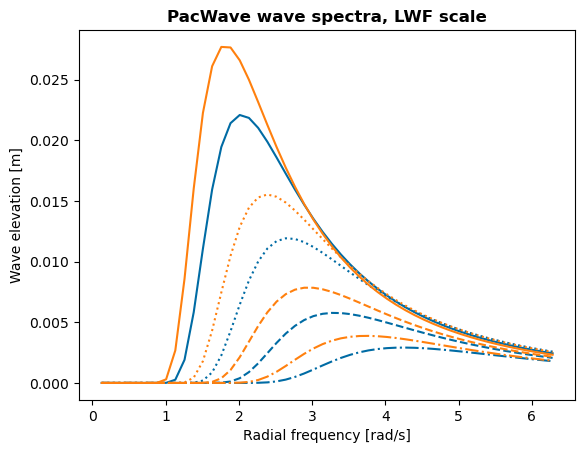

In [13]:
fig, ax = plt.subplots()
plt1 = np.abs(waves['south_max_90']).plot(
    ax=ax, color='C0', linestyle='solid', label='PW South, 90th percentile')
plt2 = np.abs(waves['south_max_annual']).plot(
    ax=ax, color='C0', linestyle='dotted', label='PW South, Max Annual')
plt3 = np.abs(waves['south_max_occurrence']).plot(
    ax=ax, color='C0', linestyle='dashed', label='PW South, Max Occurrence')
plt4 = np.abs(waves['south_min_10']).plot(
    ax=ax, color='C0', linestyle='dashdot', label='PW South, 10th percentile')
plt5 = np.abs(waves['north_max_90']).plot(
    ax=ax, color='C1', linestyle='solid', label='PW North, 90th percentile')
plt6 = np.abs(waves['north_max_annual']).plot(
    ax=ax, color='C1', linestyle='dotted', label='PW North, Max Annual')
plt7 = np.abs(waves['north_max_occurrence']).plot(
    ax=ax, color='C1', linestyle='dashed', label='PW North, Max Occurrence')
plt8 = np.abs(waves['north_min_10']).plot(
    ax=ax, color='C1', linestyle='dashdot', label='PW North, 10th percentile')

ax.set_title('PacWave wave spectra, LWF scale', fontweight='bold')
plts = plt1 + plt2 + plt3 + plt4 + plt5 + plt6 + plt7 + plt8
# ax.legend(plts, [pl.get_label() for pl in plts], ncols=1, frameon=False)

### Solve

In [19]:
# Objective function
obj_fun = pto.average_power
nstate_opt = wec.ncomponents

# Solve
scale_x_wec = 1e1
scale_x_opt = 1e-3
scale_obj = 1e-2

results = wec.solve(
    waves['south_max_occurrence'],
    # waves['regular'], 
    obj_fun, 
    nstate_opt, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
)

print(f'Optimal average electrical power: {results.fun} W')

# Post-process
nsubsteps = 5
wec_fdom, wec_tdom = wec.post_process(results, waves['south_max_occurrence'], nsubsteps)
pto_fdom, pto_tdom = pto.post_process(wec, results, waves['south_max_occurrence'], nsubsteps)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.011516968216314106
            Iterations: 54
            Function evaluations: 55
            Gradient evaluations: 54
Optimal average electrical power: -1.1516968216314105 W


### Results

(-18.171641215751894, 3.199798474165235)

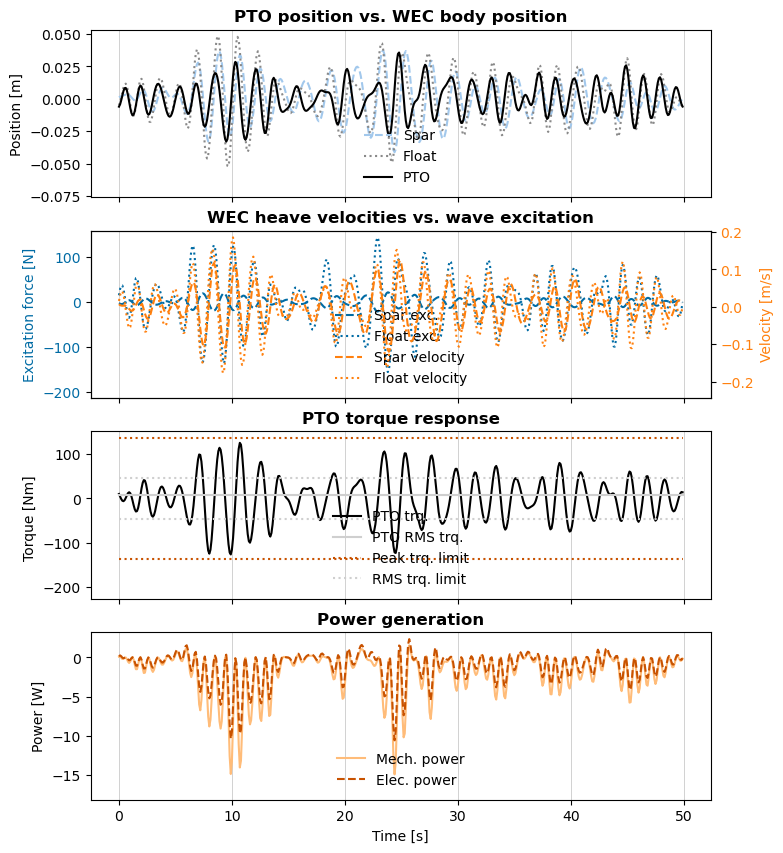

In [20]:
fig_res1, ax_res1 = plt.subplots(nrows=4, sharex=True, figsize=(8, 10))

## PTO position
wec_tdom.pos.sel(influenced_dof='spar__Heave').plot(
    ax=ax_res1[0], linestyle='dashed', color='C7', label='Spar')
wec_tdom.pos.sel(influenced_dof='float__Heave').plot(
    ax=ax_res1[0], linestyle='dotted', color='C6', label='Float')
pto_tdom.pos.plot(ax=ax_res1[0], label='PTO', color='black')

ax_res1[0].set_ylabel('Position [m]')
ax_res1[0].set_title('PTO position vs. WEC body position', fontweight='bold')
ax_res1[0].legend(loc='lower center', frameon=False)
ax_res1[0].grid(color='0.75', linestyle='-', linewidth=0.5, axis='x')
ax_res1[0].set_xlabel('')
ax_res1[0].set_ylim(bottom=ax_res1[0].get_ylim()[0]*1.33)

## Excitation and velocity
twinax = ax_res1[1].twinx()

# Spar excitation
force_excitation_spar = wec_tdom.force.sel(
    influenced_dof='spar__Heave', type=['Froude_Krylov', 'diffraction'])
force_excitation_spar = force_excitation_spar.sum('type')
plt1 = force_excitation_spar.plot(
    ax=ax_res1[1], linestyle='dashed', color='C0', label='Spar exc.')

# Float excitation
force_excitation_float = wec_tdom.force.sel(
    influenced_dof='float__Heave', type=['Froude_Krylov', 'diffraction'])
force_excitation_float = force_excitation_float.sum('type')
plt2 = force_excitation_float.plot(
    ax=ax_res1[1], linestyle='dotted', color='C0', label='Float exc.')

# Spar/float velocity
plt3 = wec_tdom.vel.sel(influenced_dof='spar__Heave').plot(
    ax=twinax, color='C1', linestyle='dashed', label='Spar velocity')
plt4 = wec_tdom.vel.sel(influenced_dof='float__Heave').plot(
    ax=twinax, color='C1', linestyle='dotted', label='Float velocity')

twinax.set_ylabel('Velocity [m/s]', color='C1')
twinax.tick_params(axis='y', labelcolor='C1')
twinax.set_title('')
twinax.autoscale(enable=True, axis='x', tight=False)
ax_res1[1].set_ylabel('Excitation force [N]', color='C0')
ax_res1[1].tick_params(axis='y', labelcolor='C0')
plts = plt1 + plt2 + plt3 + plt4
ax_res1[1].legend(plts, [pl.get_label() for pl in plts], loc='lower center', frameon=False)
ax_res1[1].set_title('WEC heave velocities vs. wave excitation', fontweight='bold')
ax_res1[1].grid(color='0.75', linestyle='-', linewidth=0.5, axis='x')
ax_res1[1].set_xlabel('')
ax_res1[1].set_ylim(bottom=ax_res1[1].get_ylim()[0]*1.25)
twinax.set_ylim(bottom=twinax.get_ylim()[0]*1.25)

## Torque
pto_tdom.force.plot(
    ax=ax_res1[2], linestyle='solid', color='black', label='PTO trq.')
pto_rms_tq  = np.sqrt(np.mean(pto_tdom.force.values**2)
                    / pto_tdom.time.values[-1])
ax_res1[2].plot(
    pto_tdom.time, pto_rms_tq * np.ones(pto_tdom.time.shape),
    color='C9', linestyle='solid', label='PTO RMS trq.')
max_tq = generator['max_torque']
rms_tq = generator['continuous_torque']
ax_res1[2].plot(
    pto_tdom.time, 1*max_tq * np.ones(pto_tdom.time.shape),
    color='C5', linestyle='dotted', label=f'Peak trq. limit')
ax_res1[2].plot(
    pto_tdom.time, -1*max_tq * np.ones(pto_tdom.time.shape),
    color='C5', linestyle='dotted')
ax_res1[2].plot(
    pto_tdom.time, 1*rms_tq * np.ones(pto_tdom.time.shape),
    color='C9', linestyle='dotted', label=f'RMS trq. limit')
ax_res1[2].plot(
    pto_tdom.time, -1*rms_tq * np.ones(pto_tdom.time.shape),
    color='C9', linestyle='dotted')
ax_res1[2].set_ylabel('Torque [Nm] ')
ax_res1[2].legend(loc='lower center', frameon=False)
ax_res1[2].set_title('PTO torque response', fontweight='bold')
ax_res1[2].grid(color='0.75', linestyle='-', linewidth=0.5, axis='x')
ax_res1[2].set_xlabel('')
ax_res1[2].set_ylim(bottom=ax_res1[2].get_ylim()[0]*1.5)

## Power
(pto_tdom['mech_power']).plot(
    ax=ax_res1[3], color='C8', label='Mech. power')
(pto_tdom['power']).plot(
    ax=ax_res1[3], color='C5', linestyle='dashed', label="Elec. power")
ax_res1[3].legend(loc='lower center', frameon=False)
ax_res1[3].set_title('Power generation', fontweight='bold')
ax_res1[3].grid(color='0.75', linestyle='-', linewidth=0.5, axis='x')
ax_res1[3].set_ylabel('Power [W]')
ax_res1[3].set_ylim(bottom=ax_res1[3].get_ylim()[0]*1.15)

Text(0.5, 0.93, 'WEC Forces')

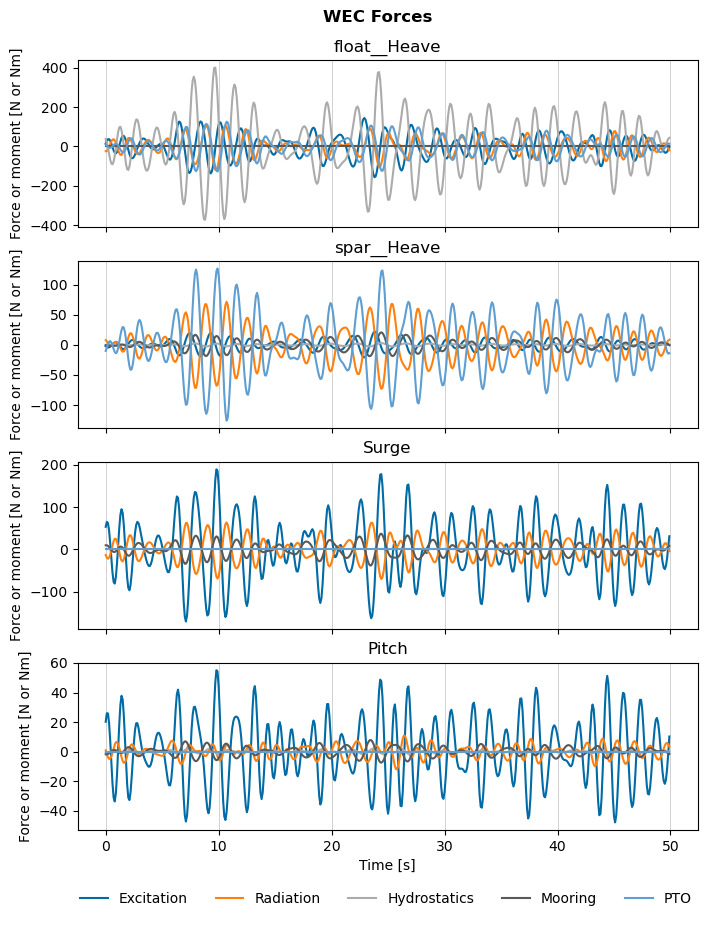

In [21]:
## Forces
fig_res2, ax_res2 = plt.subplots(len(influenced_dofs), 1, sharex=True, figsize=(8, 10))
for j, idof in enumerate(influenced_dofs):
    force_excitation = wec_tdom.force.sel(
        type=['Froude_Krylov', 'diffraction'])
    force_excitation = force_excitation.sum('type')
    force_excitation.sel(influenced_dof=idof).plot(
        ax=ax_res2[j], label='Excitation')
    wec_tdom.force.sel(influenced_dof=idof, type='radiation').plot(
        ax=ax_res2[j], label='Radiation')
    wec_tdom.force.sel(influenced_dof=idof, type='hydrostatics').plot(
        ax=ax_res2[j], label='Hydrostatics')
    wec_tdom.force.sel(influenced_dof=idof, type='Mooring').plot(
        ax=ax_res2[j], label='Mooring')
    wec_tdom.force.sel(influenced_dof=idof, type='PTO').plot(
        ax=ax_res2[j], label='PTO')
    ax_res2[j].set_title(f'{idof}')
    if j != len(influenced_dofs)-1:
        ax_res2[j].set_xlabel('')
    ax_res2[j].grid(color='0.75', linestyle='-', linewidth=0.5, axis='x')
handles_res2, labels_res2 = ax_res2[j].get_legend_handles_labels()
fig_res2.legend(handles_res2, labels_res2, loc=(0.105, 0.02), ncol=5, frameon=False)
fig_res2.suptitle('WEC Forces', fontweight='bold', y=0.93)

## Sensitivity

In [22]:
ndof = len(bem_data.radiating_dof)
x_wec, x_opt = wot.decompose_state(results.x, ndof, nfreq)
nsubsteps = 1

In [23]:
sprocket_model = default_sprocket

inputs = [
    sprockets[sprocket_model]['diameter'],
    sprockets[sprocket_model]['MOI'],
    idler_pulley['diameter'],
    idler_pulley['MOI'],
    generator['MOI'],
    generator['winding_resistance'],
    generator['winding_inductance'],
    generator['torque_constant'],
]

def average_power(
        sprocket_diameter, 
        sprocket_moi, 
        idler_pulley_diameter, 
        idler_pulley_moi,
        generator_moi,
        generator_winding_resistance,
        generator_winding_inductance,
        generator_torque_constant,
        omega = bem_data.omega.values,
        nsubsteps = nsubsteps,
        wec = wec, 
        x_wec = x_wec, 
        x_opt = x_opt,
        pto_ndof = pto_ndof, 
        kinematics = kinematics, 
        controller = controller, 
        loss = loss, 
    ):
    pulley_ratio = sprocket_diameter / idler_pulley_diameter
    drivetrain_inertia = (
        generator_moi + 
        sprocket_moi + 
        2 * idler_pulley_moi*pulley_ratio**2
    )  # N*m^2
    drivetrain_impedance = (
        1j*omega*drivetrain_inertia + 
        drivetrain_friction + 
        1/(1j*omega)*drivetrain_stiffness
    ) 
    winding_impedance = (generator_winding_resistance
                       + 1j*omega*generator_winding_inductance
    )
    pulley_radius = sprocket_diameter / 2
    pto_impedance_11 = -1* gear_ratio(pulley_radius)**2 * drivetrain_impedance
    off_diag = -1*np.ones(omega.shape) * (
        np.sqrt(3.0/2.0) * generator_torque_constant * gear_ratio(pulley_radius) + 0j)
    pto_impedance_12 = off_diag 
    pto_impedance_21 = off_diag
    pto_impedance_22 = winding_impedance
    impedance = np.array([[pto_impedance_11, pto_impedance_12],
                          [pto_impedance_21, pto_impedance_22]])
    
    pto = wot.pto.PTO(pto_ndof, kinematics, controller, impedance, loss)
    return pto.average_power(wec, x_wec, x_opt, None, nsubsteps)

dP_dDs = grad(average_power, 0)
dP_dMs = grad(average_power, 1)
dP_dDp = grad(average_power, 2)
dP_dMp = grad(average_power, 3)
dP_dMg = grad(average_power, 4)
dP_dRg = grad(average_power, 5)
dP_dLg = grad(average_power, 6)
dP_dTg = grad(average_power, 7)

print(f'average power: {average_power(*inputs)} W')
print(f'dP_dDs (sprocket diameter): {dP_dDs(*inputs)} W/m')
print(f'dP_dMs (sprocket MOI): {dP_dMs(*inputs)} W/(kg*m^2)')
print(f'dP_dDp (idler pulley diameter): {dP_dDp(*inputs)} W/m')
print(f'dP_dMp (idler pulley MOI): {dP_dMp(*inputs)} W/(kg*m^2)')
print(f'dP_dMg (generator MOI): {dP_dMg(*inputs)} W/(kg*m^2)')
print(f'dP_dRg (generator winding resistance): {dP_dRg(*inputs)} W/Ω')
print(f'dP_dLg (generator winding inductance): {dP_dLg(*inputs)} W/H')
print(f'dP_dTg (generator torque constant): {dP_dTg(*inputs)} W/(N*m/A)')

average power: -1.1516968216314105 W
dP_dDs (sprocket diameter): 3.9133919554402152 W/m
dP_dMs (sprocket MOI): 0.06874849464387844 W/(kg*m^2)
dP_dDp (idler pulley diameter): -0.01779722830925993 W/m
dP_dMp (idler pulley MOI): 0.19129813579474161 W/(kg*m^2)
dP_dMg (generator MOI): 0.06874849464387844 W/(kg*m^2)
dP_dRg (generator winding resistance): 0.07268745745665185 W/Ω
dP_dLg (generator winding inductance): -2.7504509724617794e-16 W/H
dP_dTg (generator torque constant): -0.10027623390612135 W/(N*m/A)


## Control co-design of the PTO sprocket sizing for maximum electrical power

### Setup
With our model working as expected, we can now iterate on this model with varying sprocket sizing to identify the optimal size. As with previous tutorials, we wrap the code from Part 1 into a function and iterate on our chosen design parameter (i.e. each key of the `sprockets` dictionary earlier corresponds to the `x` argument of `design_obj_fun`)

In [24]:
def design_obj_fun(x):
    global n
    n += 1

    # Unpack sprocket name
    x = x.squeeze()
    sprocket = list(sprockets.keys())[x]
    spr_rad = sprockets[sprocket]['diameter'] / 2
    spr_mass = sprockets[sprocket]['mass']
    spr_moi = sprockets[sprocket]['MOI']
    spr_des = sprockets[sprocket]['design']

    # PTO object for given sprocket
    pto = wot.pto.PTO(pto_ndof, kinematics, controller, pto_impedance(sprocket), loss, name)
    
    ## Constraints
    # Maximum stroke
    stroke_max = 0.5  # m
    def const_stroke_pto(wec, x_wec, x_opt, waves): 
        pos = pto.position(wec, x_wec, x_opt, waves, nsubsteps)
        return stroke_max - np.abs(pos.flatten())

    ## GENERATOR
    # peak torque
    radius = sprockets[sprocket]['diameter'] / 2
    def const_peak_torque_pto(wec, x_wec, x_opt, waves): 
        """Instantaneous torque must not exceed max torque Tmax - |T| >=0 
        """
        torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps) / gear_ratio(radius)
        return generator['max_torque'] - np.abs(torque.flatten())

    # continuous torque
    def const_torque_pto(wec, x_wec, x_opt, waves): 
        """RMS torque must not exceed max continous torque 
            Tmax_conti - Trms >=0 """
        torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps) / gear_ratio(radius)
        torque_rms = np.sqrt(np.mean(torque.flatten()**2))
        return generator['continuous_torque'] - torque_rms

    # max speed
    def const_speed_pto(wec, x_wec, x_opt, waves): 
        rot_vel = pto.velocity(wec, x_wec, x_opt, waves, nsubsteps) * gear_ratio(radius)
        return generator['max_speed'] - np.abs(rot_vel.flatten())

    ## Constraints
    constraints = [
        {'type': 'ineq', 'fun': const_stroke_pto},
        {'type': 'ineq', 'fun': const_peak_torque_pto},
        {'type': 'ineq', 'fun': const_torque_pto},
        {'type': 'ineq', 'fun': const_speed_pto},
    ]

    # additional forces
    f_add = {
        'PTO': pto.force_on_wec,
        'Mooring': mooring_force
    }

    # create WEC object
    wec = wot.WEC.from_bem(bem_data,
                           inertia_matrix=inertia,
                           hydrostatic_stiffness=hydrostatic_stiffness,
                           constraints=constraints,
                           friction=friction,
                           f_add=f_add,
    )

    # Objective function
    obj_fun = pto.average_power 

    print(
        f'\nRun {n} of {N}: Sprocket {sprocket}\n' +
        f'   Sprocket diameter: {spr_rad*2} m\n' +
        f'   Sprocket mass: {spr_mass} kg\n' +
        f'   Sprocket moment of inertia: {spr_moi} kg-m^2\n' +
        f'   Sprocket design: {spr_des}')

    results = wec.solve(
        waves['south_max_occurrence'],
        # waves['regular'], 
        obj_fun, 
        nstate_opt, 
        scale_x_wec=scale_x_wec,
        scale_x_opt=scale_x_opt,
        scale_obj=scale_obj,
    )
    print(f'Optimal average electrical power: {results.fun:.2f} W')
    return results.fun 

Given there are only 22 sprockets, we will continue to use a brute force algorithm. Note that the code below will likely take several hours to run.

In [25]:
global n; n = 0 
global N; N = len(sprockets)
ranges = slice(0, N, 1),

# solve
opt_x0, opt_fval, x0s, fvals = brute(
    func=design_obj_fun,
    ranges=ranges,
    full_output=True,
    finish=None)


Run 1 of 22: Sprocket 8MX-32S-36
   Sprocket diameter: 0.0814832 m
   Sprocket mass: 0.7711064 kg
   Sprocket moment of inertia: 0.0008428015143936001 kg-m^2
   Sprocket design: AF-1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.012602225169153698
            Iterations: 62
            Function evaluations: 63
            Gradient evaluations: 62
Optimal average electrical power: -1.26 W

Run 2 of 22: Sprocket 8MX-33S-36
   Sprocket diameter: 0.08402319999999999 m
   Sprocket mass: 1.50138952 kg
   Sprocket moment of inertia: 0.00092708166583296 kg-m^2
   Sprocket design: AF
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.012620326203482315
            Iterations: 69
            Function evaluations: 70
            Gradient evaluations: 69
Optimal average electrical power: -1.26 W

Run 3 of 22: Sprocket 8MX-34S-36
   Sprocket diameter: 0.08658859999999999 m
   Sprocket mass: 0.8164656 kg
   Spr

### Results
The power generation for all the sprockets are plotted below, with the three sprockets possessed by Oregon State University called out. Comparing the results across the range of sprocket sizes, it is clear that power generation is maximized when sprocket dimensions are minimized. Thus, the 8MX-32S-36 sprocket is the best sprocket selection for LUPA for the selected wave case.

The motivation to include an interchangeable sprocket in LUPA is to make it versatile across different locations and wave conditions. The optimal sprocket could be different when tested with a more or less severe wave climate, or a different mooring configuration. Try different `wave_cases` keys or modify the mooring system parameters (`init_fair_coords`, `anch_coords`, `line_ax_stiff`, and `pretension`) and see how the WEC response changes and which sprocket generates the most power.

In [26]:
spr_names = list(sprockets.keys())
spr_diameters = np.zeros(len(spr_names))
for i, spr in enumerate(spr_names):
    spr_diameters[i] = sprockets[spr]['diameter']

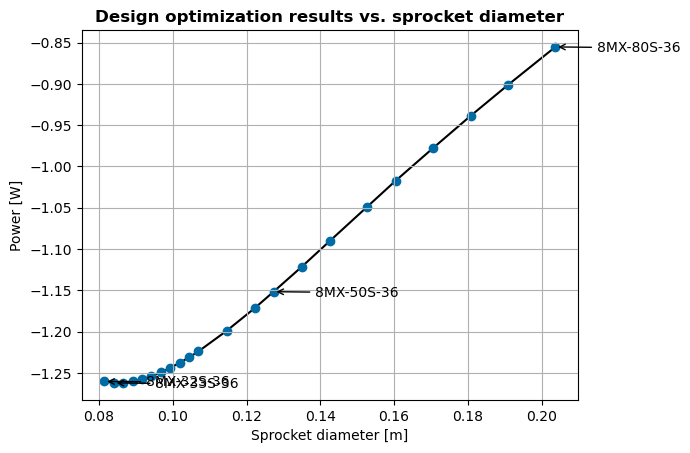

In [27]:
fig1, ax1 = plt.subplots()
ax1.grid()
ax1.plot(spr_diameters, fvals, 'k', zorder=0)
ax1.scatter(spr_diameters, fvals, zorder=1)
ax1.set_xlabel('Sprocket diameter [m]')
ax1.set_ylabel('Power [W]')
ax1.set_title('Design optimization results vs. sprocket diameter', fontweight='bold')
osu_sprockets = ['8MX-32S-36', '8MX-50S-36', '8MX-80S-36']
for i, spr in enumerate(spr_names):
    if spr in spr_names[int(opt_x0.squeeze())]:
        ax1.annotate(
            spr,
            xy=(spr_diameters[i], fvals[i]),
            xytext=(30, -3.5),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', facecolor='black'))
    elif spr in osu_sprockets:
        ax1.annotate(spr,
        xy=(spr_diameters[i],
        fvals[i]),
        xytext=(30, -3.5),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', facecolor='black'))

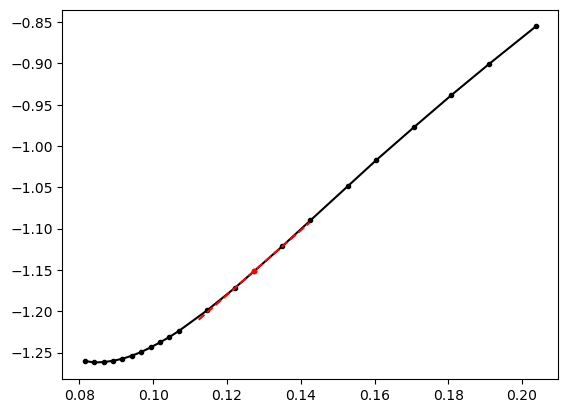

In [45]:
idx = 13

plt.figure()
plt.plot(spr_diameters, fvals, 'k.-')
plt.plot(spr_diameters[idx], fvals[idx], 'r.')

dx = 0.015
x = np.array([spr_diameters[idx]-dx, spr_diameters[idx]+dx])
m = dP_dDs(*inputs)
b = fvals[idx] - m*spr_diameters[idx]
y = m*x + b

plt.plot(x, y, 'r--')